In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import glob
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from IPython.display import clear_output
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import glob

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
action_names=['jump', 'kick', 'punch', 'run', 'sit','squat', 'stand', 'walk', 'wave']

In [4]:
dir='kps'
files=glob.glob(dir+'/*/*')
len(files), files[:2]

(74,
 ['kps/stand_03-08-20-35-06-287/stand_060-500_441.txt',
  'kps/kick_03-13-16-18-12-361/kick_203-237_35.txt'])

In [5]:
action_files=defaultdict(list)
for file in files:
    action=file.split('/')[1].split('_')[0]
    action_files[action].append(file)

action_files.keys()

dict_keys(['stand', 'kick', 'wave', 'squat', 'punch', 'run', 'jump', 'walk', 'sit'])

In [6]:
def load_merge_action_files(action_files, action_name):
    """
    action_files: dict, key: action_name, value: list of file names
    """
    action=[]
    for fn in action_files[action_name]:
        a=np.loadtxt(fn)
        action.append(a)

    action=np.vstack(action)
    return action

In [7]:
action_jump=load_merge_action_files(action_files, 'jump')
action_jump.shape

(1174, 66)

In [8]:
seq_len=10
seq_len=20
X=[]
y=[]
for c, action_name in enumerate(action_names):
    action=load_merge_action_files(action_files, action_name)
    n=(action.shape[0]//seq_len)*seq_len
    action=action[:n].reshape(-1, seq_len, action.shape[1])
    X.append(action)
    label=np.ones(action.shape[0])*c
    y.append(label)
    print(action_name, action.shape, label.shape)

jump (58, 20, 66) (58,)
kick (58, 20, 66) (58,)
punch (39, 20, 66) (39,)
run (51, 20, 66) (51,)
sit (95, 20, 66) (95,)
squat (48, 20, 66) (48,)
stand (61, 20, 66) (61,)
walk (61, 20, 66) (61,)
wave (61, 20, 66) (61,)


In [9]:
X=torch.from_numpy(np.vstack(X)).float()
y=torch.from_numpy(np.hstack(y)).reshape(-1,1)
X.shape, y.shape

(torch.Size([532, 20, 66]), torch.Size([532, 1]))

In [10]:
#train test split
# n=X.shape[0]
# n_train=int(n*0.8)
# X_train, y_train=X[:n_train], y[:n_train]
# X_test, y_test=X[n_train:], y[n_train:]
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [11]:
ids=np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids=ids[:int(len(ids)*0.8)]
test_ids=ids[int(len(ids)*0.8):]
X_train, y_train=X[train_ids], y[train_ids]
X_test, y_test=X[test_ids], y[test_ids]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([425, 20, 66]),
 torch.Size([425, 1]),
 torch.Size([107, 20, 66]),
 torch.Size([107, 1]))

In [12]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num, seq_len):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(seq_len)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return action_name[category_i], category_i

In [14]:
# import random
# def randomTrainingExampleBatch(batch_size,flag,num=-1):
#     data_size = X.shape[0]
#     if num == -1:
#         ran_num = random.randint(0,data_size-batch_size)
#     else:
#         ran_num = num
#     pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
#     category_tensor = y[ran_num:ran_num+batch_size,:] 
#     return category_tensor.long(),pose_sequence_tensor

In [15]:
import random
n_data_size_train = X_train.shape[0]
n_data_size_test = X_test.shape[0]

def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = X_train
        y = y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = X_test
        y = y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

In [16]:
n_hidden = 128
n_joints = 33*2
n_categories = len(action_names)
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer, seq_len)
rnn.to(device)

LSTM(
  (lstm): LSTM(66, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [17]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

In [18]:
# n_iters = 100000
n_iters = 60000
print_every = 1000
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

 
start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
 
    current_loss += loss.item()

    print('iter: %d, loss: %.3f' % (iter, loss.item()))
    
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

iter: 1, loss: 2.200
iter: 2, loss: 2.201
iter: 3, loss: 2.200
iter: 4, loss: 2.204
iter: 5, loss: 2.199
iter: 6, loss: 2.200
iter: 7, loss: 2.200
iter: 8, loss: 2.201
iter: 9, loss: 2.200
iter: 10, loss: 2.201
iter: 11, loss: 2.200
iter: 12, loss: 2.201
iter: 13, loss: 2.200
iter: 14, loss: 2.201
iter: 15, loss: 2.203
iter: 16, loss: 2.200
iter: 17, loss: 2.200
iter: 18, loss: 2.200
iter: 19, loss: 2.200
iter: 20, loss: 2.198
iter: 21, loss: 2.203
iter: 22, loss: 2.205
iter: 23, loss: 2.199
iter: 24, loss: 2.201
iter: 25, loss: 2.200
iter: 26, loss: 2.200
iter: 27, loss: 2.201
iter: 28, loss: 2.203
iter: 29, loss: 2.199
iter: 30, loss: 2.204
iter: 31, loss: 2.203
iter: 32, loss: 2.203
iter: 33, loss: 2.202
iter: 34, loss: 2.199
iter: 35, loss: 2.199
iter: 36, loss: 2.200
iter: 37, loss: 2.197
iter: 38, loss: 2.203
iter: 39, loss: 2.198
iter: 40, loss: 2.200
iter: 41, loss: 2.198
iter: 42, loss: 2.203
iter: 43, loss: 2.199
iter: 44, loss: 2.199
iter: 45, loss: 2.200
iter: 46, loss: 2.1

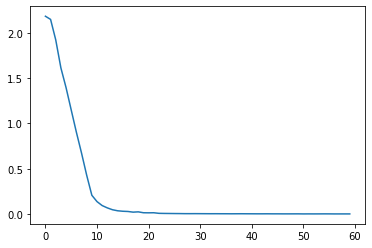

In [22]:
plt.plot(all_losses)

In [23]:
rnn.eval()

LSTM(
  (lstm): LSTM(66, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
#test 

rnn.eval()

n_correct = 0
n_total = 0
for i in range(n_data_size_test):
    category_tensor, input_sequence = randomTrainingExampleBatch(1,'test',i)
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    output = rnn(input_sequence)
    po=output.argmax(axis=1)
    guess=action_names[po.item()] 
    category = action_names[category_tensor]
    if category == guess:
        n_correct += 1
    n_total += 1

print('Accuracy of %d test data: %.3f%%' % (n_data_size_test, n_correct / n_total * 100))

Accuracy of 107 test data: 91.589%


In [25]:
# xt=X_test.to(device)
# out=rnn(xt)
# po=out.argmax(axis=1).cpu().detach().numpy()
# po 

In [26]:
# y_test

In [27]:
action_names

['jump', 'kick', 'punch', 'run', 'sit', 'squat', 'stand', 'walk', 'wave']

In [28]:
action_name='jump'
action_name=action_names[2]
action=load_merge_action_files(action_files, action_name)
n=(action.shape[0]//seq_len)*seq_len
action=action[:n].reshape(-1, seq_len, action.shape[1])


tx=torch.from_numpy(action).float().to(device)
output = rnn(tx).cpu().detach().numpy()
po=output.argmax(axis=1)
po

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2])

In [29]:
action_name=action_names[8]
action=load_merge_action_files(action_files, action_name)
n=(action.shape[0]//seq_len)*seq_len
action=action[:n].reshape(-1, seq_len, action.shape[1])


tx=torch.from_numpy(action).float().to(device)
output = rnn(tx).cpu().detach().numpy()
po=output.argmax(axis=1)
po

array([0, 8, 8, 6, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

### load image files , extract kps and predict

In [30]:
# tfn='source_images3/wave_03-13-13-23-25-262'

In [31]:
meta_fn='source_images3/valid_images.txt'
with open(meta_fn) as f:
    valid_images=f.readlines()

info=[line.strip() for line in valid_images]

datas=defaultdict(list)
activity=None
actions=defaultdict(list)   
for line in info:
    if '_' in line:
        activity=line
        action=line.split('_')[0]
    elif line=='':
        continue
    else:
        s,e=line.split()
        s,e=int(s), int(e)
        datas[activity].append( (s,e) )
        actions[action].append( (s,e, activity) )
for key in datas:
    print(key, len(datas[key]))
print('---')

jump_03-02-12-34-01-795 16
jump_03-12-09-18-26-176 1
jump_03-13-11-27-50-720 1
kick_03-02-12-36-05-185 18
kick_03-08-20-32-41-586 2
kick_03-12-09-23-41-176 1
kick_03-13-16-18-12-361 4
punch_03-12-09-21-27-876 1
run_03-02-12-31-47-095 1
run_03-12-09-15-25-375 1
sit_03-02-12-27-51-085 1
sit_03-02-12-28-32-893 1
sit_03-12-09-25-43-527 1
sit_03-13-16-15-56-861 15
squat_03-08-20-26-57-195 1
squat_03-13-13-21-48-761 1
stand_03-08-20-24-55-587 1
stand_03-08-20-35-06-287 1
stand_03-12-09-17-05-376 2
stand_03-13-13-22-37-869 1
walk_03-12-09-13-10-875 1
walk_03-02-12-30-23-393 1
wave_03-08-20-28-39-387 1
wave_03-13-13-23-25-262 1
---


In [32]:
dir='source_images3/'
def view_activity(activity_fn, s,e, delay=0.2, return_img=False):
    fn=dir+activity_fn
    imgs=[] if return_img else None
    for i in range(s,e+1):
        fni=f'{fn}/{i:05d}.jpg'
        img=cv2.imread(fni)
        if return_img: imgs.append(img)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img) 
        plt.show()
        time.sleep(delay)
        clear_output(wait=True)
    return imgs

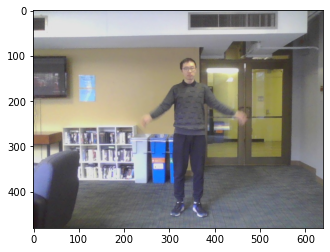

In [33]:
activity_fn='wave_03-13-13-23-25-262'
ses=datas[activity_fn]
s,e=ses[0]
e=s+seq_len-1

imgs=view_activity(activity_fn, s,e, return_img=True)

In [34]:
print(s,e, len(imgs))  

47 66 20


In [35]:
pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
def extract_keypoints(image_rgb): 
    try:
        results = pose.process(image_rgb)
        landmarks=results.pose_landmarks.landmark
    except Exception as e:
        # print('Error file=', fn)
        # print('Error=', e)
        return None
    xys=[]
    for landmark in landmarks:
        xys.append([landmark.x, landmark.y])
    xys=np.array(xys)
    return xys

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [36]:
dir='source_images3/'
def action_segment_extract_kps(activity_fn, start_i, end_i):
    jump1=[]
    for i in range(start_i,end_i+1):
        fn=f'{dir}{activity_fn}/{i:05d}.jpg' 
        # print('fn=',fn)
        
        img = cv2.imread(fn) 
        image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        xys=extract_keypoints(image_rgb)
        xys=xys.ravel()

        jump1.append(xys)
    return np.array(jump1)

In [37]:
action=action_segment_extract_kps(activity_fn, s, e)
action.shape

(20, 66)

In [38]:
tx=torch.from_numpy(action).float().to(device).unsqueeze(0)
output = rnn(tx).cpu().detach().numpy()
po=output.argmax(axis=1)
prediction=action_names[po[0]]
print('prediction=', prediction)

prediction= jump


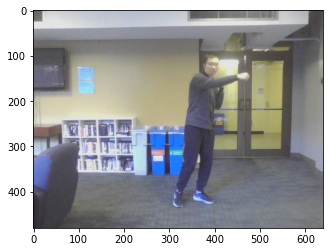

In [39]:
activity_fn='punch_03-12-09-21-27-876'
ses=datas[activity_fn]

s,e=ses[0]
e=s+seq_len-1

imgs=view_activity(activity_fn, s,e, return_img=True) 

In [40]:
print(s,e, len(imgs)) 

60 79 20


In [41]:
action=action_segment_extract_kps(activity_fn, s, e)
tx=torch.from_numpy(action).float().to(device).unsqueeze(0)
output = rnn(tx).cpu().detach().numpy()
po=output.argmax(axis=1)
prediction=action_names[po[0]]
print('prediction=', prediction)

prediction= punch


In [56]:
fn='output_trim.avi'
fn='jump1.mp4'
fn='wave2.mp4'

video=cv2.VideoCapture(fn)
imgs=[]
while(video.isOpened()):
    ret, frame = video.read()
    if ret==False: break
    imgs.append(frame)
video.release() 

In [49]:
imgs2=[]
for i in range(0, len(imgs), 5):
    imgs2.append(imgs[i])
len(imgs2)

53

In [50]:
# imgs2=imgs2[25:35]
imgs2=imgs2[20:40]
len(imgs2)

20

In [58]:
imgs2=[]
for i in range(0, len(imgs), 5):
    imgs2.append(imgs[i])
len(imgs2)

34

In [60]:
imgs2=imgs2[7:]
len(imgs2)

20

In [ ]:
for img in imgs2:
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

In [62]:
len(imgs2)

20

In [63]:
jump1=[]
for img in imgs2:
    image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    xys=extract_keypoints(image_rgb)
    xys=xys.ravel()

    jump1.append(xys)
action=np.array(jump1)
action.shape

(20, 66)

In [64]:
tx=torch.from_numpy(action).float().to(device).unsqueeze(0)
output = rnn(tx).cpu().detach().numpy()
po=output.argmax(axis=1)
prediction=action_names[po[0]]
print('prediction=', prediction)

prediction= wave


In [65]:
output

array([[ 4.942507 , -2.01133  ,  4.1241374,  0.3424598, -5.3599515,
        -3.1477933, -5.5768094, -4.3954678, 11.282352 ]], dtype=float32)

In [66]:
action_names

['jump', 'kick', 'punch', 'run', 'sit', 'squat', 'stand', 'walk', 'wave']